In [1]:
!pip install torch torchvision transformers scikit-learn matplotlib einops spectral wandb

In [99]:
import os

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from tqdm import tqdm

import matplotlib.pyplot as plt

from einops import rearrange
from einops.layers.torch import Rearrange

import spectral.io.envi as envi

import wandb

In [3]:
header_file = "ENSSAT_Dataset/header.hdr"
spectral_file = "ENSSAT_Dataset/data.pix"

data = envi.open(header_file, spectral_file)

In [4]:
default_red, default_green, default_blue = data.metadata['default bands']
default_red = int(default_red)
default_green = int(default_green)
default_blue = int(default_blue)
default_red, default_green, default_blue

(95, 58, 20)

In [5]:
d = data[:, :, :]
mean_per_layer = np.mean(d, axis=(0, 1))
std_per_layer = np.std(d, axis=(0, 1))

In [6]:
def normalize_houston(x):
    return (x - mean_per_layer[np.newaxis, np.newaxis, :]) / std_per_layer[np.newaxis, np.newaxis, :]

In [7]:
def update_type_float32(x):
    return x.type(torch.float32)

In [8]:
transform = transforms.Compose([
    normalize_houston,
    transforms.ToTensor(),
    update_type_float32,
])

In [9]:
class SpectralDataset(Dataset):
    def __init__(self, data, pad_x, pad_y, transform):
        self.data = data
        self.pad_x = pad_x
        self.pad_y = pad_y
        self.transform = transform
        if data.shape[0] < pad_x or data.shape[1] < pad_y:
            raise ValueError(f"Padding should be lower than data shape {data.shape=}")
        
    def __len__(self):
        return (self.data.shape[0] - self.pad_x) * (self.data.shape[1] - self.pad_y)

    def __getitem__(self, index):
        x = index % (self.data.shape[0] - self.pad_x)
        y = index // (self.data.shape[0] - self.pad_x)
        img = self.data[x : x + self.pad_x, y : y + self.pad_y, :]
        transformed_img = self.transform(img).transpose(0, 2)
        return transformed_img

In [10]:
def custom_collate(batch):
    # Filter out mostly black images based on a threshold
    threshold = 0.1
    filtered_batch = [sample for sample in batch if sample.mean() > threshold]

    samples = [sample for sample in filtered_batch]

    if not samples:
        return None

    stacked_samples = torch.stack(samples, dim=0)

    return stacked_samples

In [11]:
pad_x, pad_y = 8, 8
dataset = SpectralDataset(data, 8, 8, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, collate_fn=custom_collate, shuffle=True)

In [12]:
for batch in dataloader:
    break

In [13]:
def show_images(images, R=default_red, G=default_green, B=default_blue):    
    if type(images) != list:
        images = [images]
    if len(list(images[0].shape)) == 4:
        images = [img for img in images[0]]
    fig, axes = plt.subplots(1, len(images))
    if len(images) == 1:
        axes = [axes]
    for i, img in enumerate(images):
        axes[i].imshow(img[:, :, [R, G, B]])
        axes[i].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


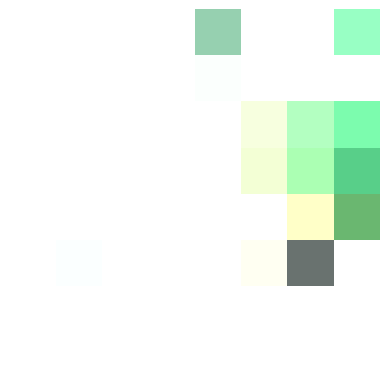

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


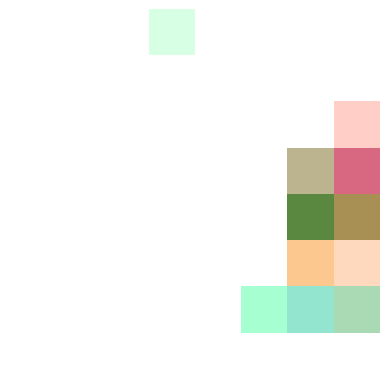

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


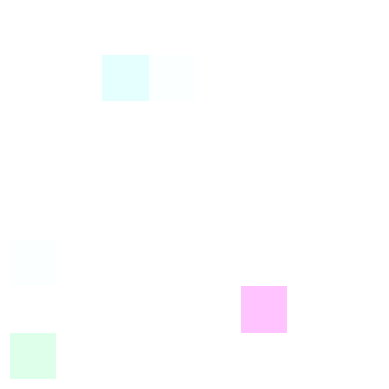

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


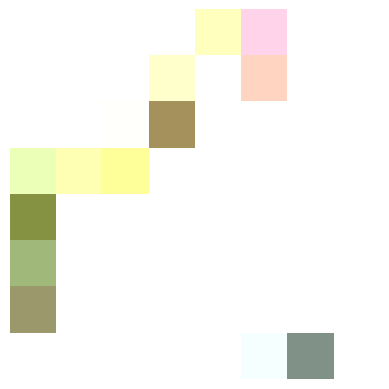

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


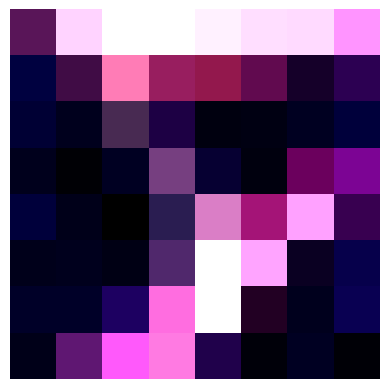

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


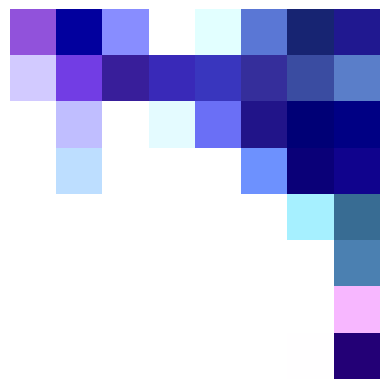

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


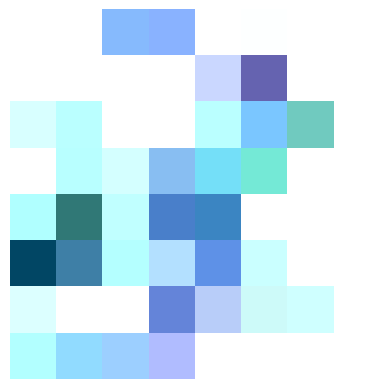

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


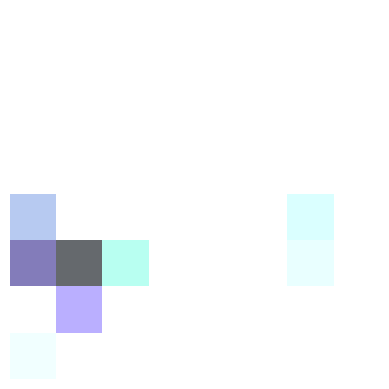

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


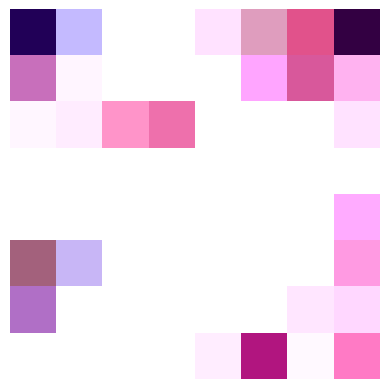

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


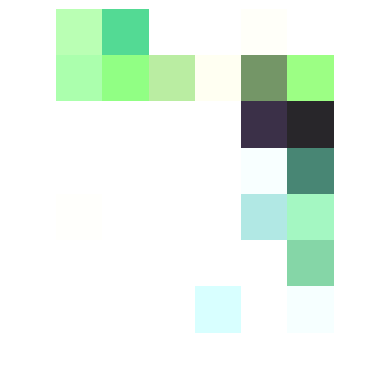

In [14]:
for img in batch:
    show_images(img)

In [15]:
def show_full_image(data):
    img = data[:, :, [default_red, default_green, default_blue]]
    img = img / img.max()
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    plt.show()

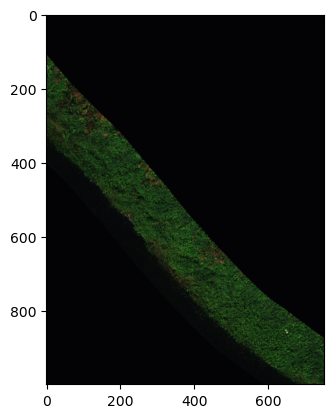

In [16]:
show_full_image(data)

In [17]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b (h p1) (w p2) c -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = posemb_sincos_2d(
            h = image_height // patch_height,
            w = image_width // patch_width,
            dim = dim,
        ) 

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = "mean"
        self.to_latent = nn.Identity()

        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        
        device = img.device

        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = SimpleViT(
    image_size=pad_x,
    patch_size=1,
    num_classes=20,
    dim=20,
    depth=5,
    heads=3,
    mlp_dim=5,
    channels=int(data.metadata["bands"])
).to(device)

In [20]:
model(batch).shape

torch.Size([10, 20])

In [21]:
# Contrastive loss
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
early_stopping_at = 0.003

In [22]:
def apply_gaussian_noise(batch, mean=0, std=1):
    noise = torch.randn_like(batch) * std + mean
    noisy_batch = batch + noise
    return noisy_batch

In [23]:
os.environ["WANDB_NOTEBOOK_NAME"] = "ENSSAT_DATA.ipynb"

wandb.init(
    # set the wandb project where this run will be logged
    project="ENSSAT_POC",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 3e-4,
    "architecture": "ViT",
    "dataset": "ENSSAT",
    "epochs": 10,
    "early_stopping_at": early_stopping_at
    }
)

wandb: Currently logged in as: mattias-kockum (enssat-projet-technologique). Use `wandb login --relogin` to force relogin


In [24]:
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(dataloader):
        batch = batch.to(device)
        
        # Contrastive learning
        negative_pairs = batch.roll(shifts=-1, dims=0).clone()
        negative_pairs[-1] = batch[0].clone()
        positive_pairs = apply_gaussian_noise(batch, std=0.1)
        
        # Forward pass
        embeddings_anchor = F.normalize(model(batch), dim=-1)
        embeddings_positive = F.normalize(model(positive_pairs), dim=-1)
        embeddings_negative = F.normalize(model(negative_pairs), dim=-1)

        # Contrastive loss
        loss = triplet_loss(embeddings_anchor, embeddings_positive, embeddings_negative)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            wandb.log({"loss": loss.item(), "epoch": epoch})
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")
            if loss.item() < early_stopping_at:
                break
    if loss.item() < early_stopping_at:
                break
            
wandb.finish()

Epoch [1/10], Batch [0/11501], Loss: 0.3404
Epoch [1/10], Batch [100/11501], Loss: 0.0380
Epoch [1/10], Batch [200/11501], Loss: 0.1390
Epoch [1/10], Batch [300/11501], Loss: 0.0542
Epoch [1/10], Batch [400/11501], Loss: 0.0310
Epoch [1/10], Batch [500/11501], Loss: 0.1199
Epoch [1/10], Batch [600/11501], Loss: 0.0877
Epoch [1/10], Batch [700/11501], Loss: 0.0183
Epoch [1/10], Batch [800/11501], Loss: 0.0356
Epoch [1/10], Batch [900/11501], Loss: 0.0259
Epoch [1/10], Batch [1000/11501], Loss: 0.0228
Epoch [1/10], Batch [1100/11501], Loss: 0.0000


epoch,▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▄▂▂▃▃▁▂▂▁▁
epoch,0
loss,0.0


In [25]:
torch.save(model.state_dict(), "ENSSAT_POC_Model")

In [26]:
all_embeddings = []

model.eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(dataloader):
        batch = batch.to(device)
        embedding = F.normalize(model(batch), dim=-1)
        all_embeddings.append(embedding)
        if batch_idx > 100:
            break

all_embeddings = torch.cat(all_embeddings, dim=0)
all_embeddings_np = all_embeddings.detach().numpy()
num_clusters = 21
all_embeddings_flattened = all_embeddings_np.reshape(all_embeddings_np.shape[0], -1)

kmeans = KMeans(n_clusters=num_clusters, n_init="auto", random_state=0)
cluster_labels = kmeans.fit_predict(all_embeddings_flattened)

print(cluster_labels)

[ 8  4  2 ... 19 19  3]


In [92]:
X1 = 200
Y1 = 0
X2 = 400
Y2 = 200
dataset.data.shape

(1000, 750, 224)

In [93]:
sub_dataset = SpectralDataset(data[X1:X2, Y1:Y2, :], pad_x, pad_y, transform=transform)

In [94]:
output_array = np.zeros(len(sub_dataset))

In [95]:
with torch.no_grad():
    for i in tqdm(range(len(output_array))):
        embedding = model(sub_dataset[i].unsqueeze(0)).detach().numpy()
        pred = kmeans.predict(embedding)
        output_array[i] = pred[0]

100%|██████████| 36864/36864 [03:58<00:00, 154.27it/s]


In [96]:
out_img = output_array.reshape((Y2 - Y1 - pad_y, X2 - X1 - pad_x)).T

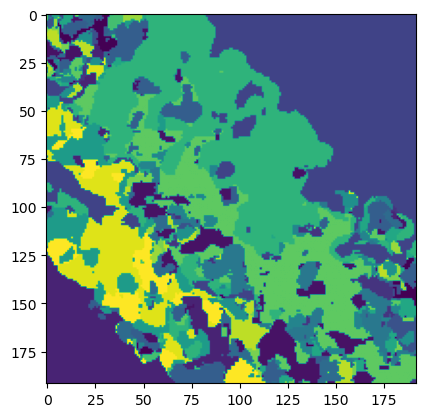

In [97]:
plt.imshow(out_img)

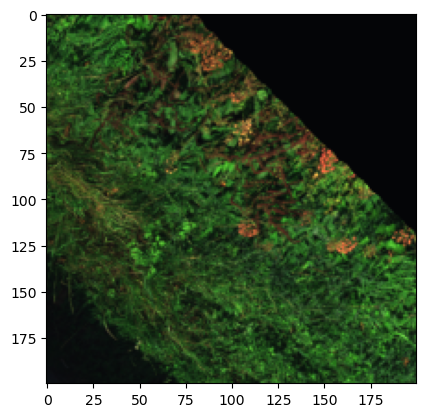

In [98]:
show_full_image(data[X1:X2, Y1:Y2, :])

In [103]:
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings_np)

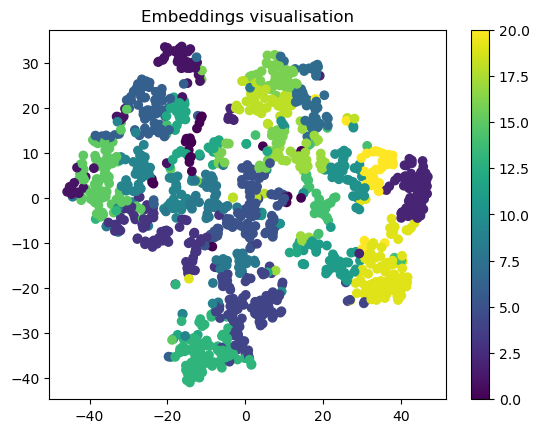

In [104]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels)
plt.title('Embeddings visualisation')
plt.colorbar()
plt.show()